<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/Unsupervised_Learning/Example_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# K-means clustering
x, y = make_blobs(n_samples=100, centers=4, n_features=2, cluster_std=[1, 1.5, 2, 2], random_state=7)
df_blobs = pd.DataFrame({
    'x1': x[:,0], 'x2': x[:,1], 'y': y
})

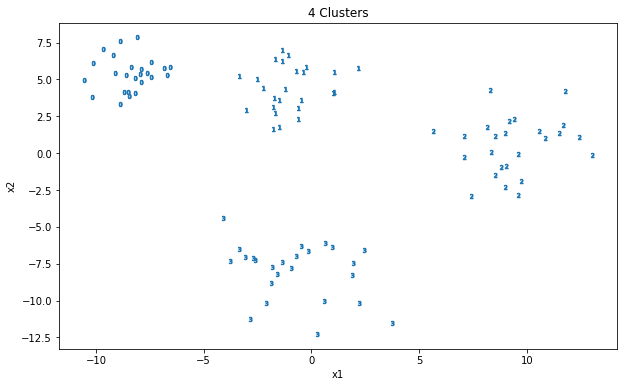

In [3]:
# Visualizing sample data
def plot_2d_clusters(x, y, ax):
  y_uniques = pd.Series(y).unique()
  for y_unique_item in y_uniques:
    x[y==y_unique_item].plot(title=f'{len(y_uniques)} Clusters',
                             kind='scatter', x='x1', y='x2',
                             marker=f'${y_unique_item}$', ax=ax)
    
fig, ax = plt.subplots(1,1,figsize=(10,6))
x, y = df_blobs[['x1','x2']], df_blobs['y']
plot_2d_clusters(x, y, ax)

Text(0.5, 1.0, 'KMeans: 5 Clusters')

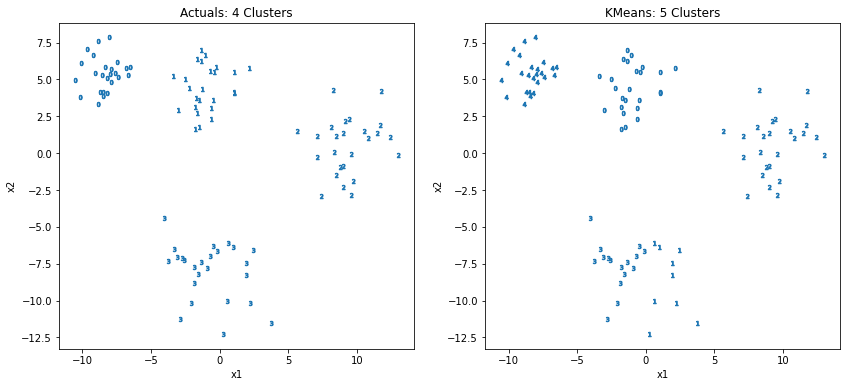

In [15]:
kmeans = KMeans(n_clusters=5, random_state=7)
x, y = df_blobs[['x1', 'x2']], df_blobs['y']
y_pred = kmeans.fit_predict(x)

fig, axs = plt.subplots(1,2,figsize=(14, 6))
plot_2d_clusters(x, y, axs[0])
plot_2d_clusters(x, y_pred, axs[1])

axs[0].set_title(f'Actuals: {axs[0].get_title()}')
axs[1].set_title(f'KMeans: {axs[1].get_title()}')

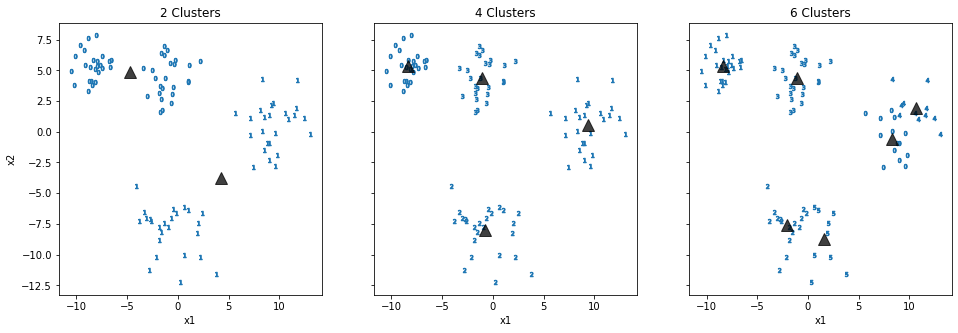

In [20]:
# Trying different numbers of clusters
n_clusters_options = [2,4,6]

fig, axs = plt.subplots(1, len(n_clusters_options), figsize=(16,5), sharey=True)

for i, n_clusters in enumerate(n_clusters_options):
  kmeans = KMeans(n_clusters=n_clusters, random_state=7)
  y_pred = kmeans.fit_predict(x)
  plot_2d_clusters(x, y_pred, axs[i])
  axs[i].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'k^', ms=12, alpha=0.75)

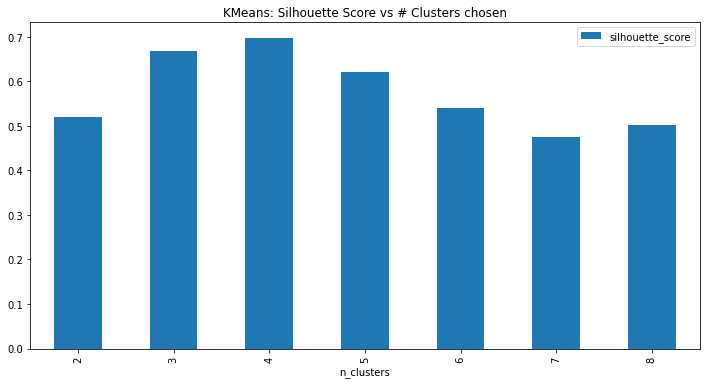

In [22]:
# Calculating the Silhouette score
n_clusters_options = [2,3,4,5,6,7,8]
silhouette_scores = []

for i, n_clusters in enumerate(n_clusters_options):
  kmeans = KMeans(n_clusters=n_clusters, random_state=7)
  y_pred = kmeans.fit_predict(x)
  silhouette_scores.append(silhouette_score(x, y_pred))

fig, ax = plt.subplots(1,1,figsize=(12,6))

pd.DataFrame({
    'n_clusters': n_clusters_options,
    'silhouette_score':  silhouette_scores
}).set_index('n_clusters').plot(title='KMeans: Silhouette Score vs # Clusters chosen',
                                kind='bar', ax=ax)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


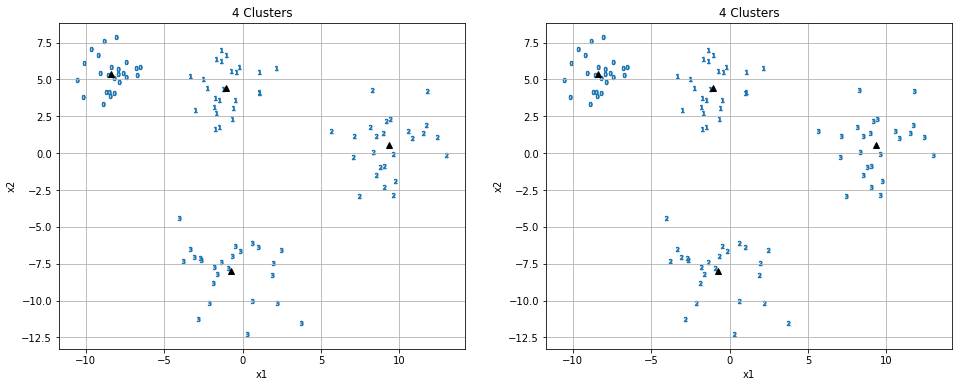

In [6]:
# Choosing initial centroids
initial_centroids_options = np.array([
    [(-10,5), (0,5), (10,0), (-10,0)], [(0,0), (0.1,0.1), (0,0), (0.1,0.1)]                                  
])

fig, axs = plt.subplots(1,2,figsize=(16,6))
for i, initial_centroids in enumerate(initial_centroids_options):
  kmeans = KMeans(init=initial_centroids, max_iter=500, n_clusters=4, random_state=7)
  y_pred = kmeans.fit_predict(x)
  plot_2d_clusters(x, y_pred, axs[i])
  axs[i].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'k^')
  axs[i].grid()